In [1]:
import gym
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow import keras
from src.env_wrapper import EnvWrapper
from IPython.display import clear_output

In [2]:
gym_env = gym.make("BreakoutNoFrameskip-v4")
env = EnvWrapper(gym_env, frame_stack=4, frame_skip=4, seed=42)

In [3]:
def epsilon_greedy_policy(state, model):
  epsilon = 0.05
  if np.random.rand() < epsilon:
    return np.random.randint(env.action_space.n)
  else:
    state_tensor = tf.expand_dims(tf.convert_to_tensor(state), 0)
    action_probs = model(state_tensor)
    return tf.argmax(action_probs[0]).numpy()

In [4]:
def plot_training_data(arpe, aav):
  f, (ax1, ax2) = plt.subplots(2, sharex=True)
  f.tight_layout()
  for name in arpe.keys():
    ax1.plot(arpe[name], label = name)
    ax2.plot(aav[name], label = name)
  ax1.set_title('Average Reward Per Episode')
  ax1.set_ylim(0, 3.5)
  ax1.legend()
  ax1.grid()
  ax2.set_title('Average Action Value (Q)')  
  ax2.set_xlabel('Epochs')
  ax2.grid()
  plt.show()

def plot_evaluation(eval):
  for name, e in eval.items():
    plt.plot(e, label = name)
  plt.title("Average Reward Per Episode")
  plt.xlabel("Episodes")
  plt.ylim(0, 30)
  plt.legend()
  plt.grid()
  plt.show()

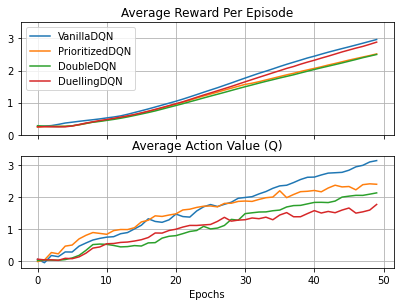

In [5]:
path = "./models/"
model_names = ["VanillaDQN", "PrioritizedDQN", "DoubleDQN", "DuellingDQN"]
models = {}
arpe = {}
aav = {}
eval = {}
for name in model_names:
  if name != "DuellingDQN": models[name] = keras.models.load_model(path + name + "/model_adam/")
  else: models[name] = keras.models.load_model(path + name + "/model_adam/", custom_objects={'tf': tf})
  arpe[name] = [float(i) for i in pd.read_csv(path + name + "/model_adam/arpe.csv", names=["arpe"])["arpe"].values.tolist()[1:]]
  aav[name] = [float(i) for i in pd.read_csv(path + name + "/model_adam/aav.csv", names=["aav"])["aav"].values.tolist()[1:]]
  eval[name] = np.array([])
clear_output(wait=True)
plot_training_data(arpe, aav)

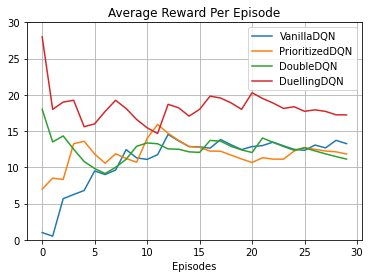

In [6]:
for name, model in models.items():
  observation = env.reset()
  games = 30
  temp_arpe = 0
  episode_reward = 0
  while games:
    action = epsilon_greedy_policy(observation, model)
    observation, reward, done, info = env.step(action)
    episode_reward += reward
    if done:
      observation = env.reset()
      games -= 1
      temp_arpe = temp_arpe + (episode_reward - temp_arpe) / (30 - games)
      eval[name] = np.append(eval[name], temp_arpe)
      episode_reward = 0
env.close()
plot_evaluation(eval)